In [1]:
%config Completer.use_jedi = False

From HyunWoo Kim

In [2]:
import pandas as pd #Analysis 
import matplotlib.pyplot as plt #Visulization
import seaborn as sns #Visulization
import numpy as np #Analysis 
from scipy.stats import norm #Analysis 
from sklearn.preprocessing import StandardScaler #Analysis 
from scipy import stats #Analysis 
import warnings 
warnings.filterwarnings('ignore')
%matplotlib inline
import gc

/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/Users/sanghyub/anaconda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
pd.options.display.max_columns = 30

In [4]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

In [5]:
print('train shape: ', df_train.shape)
print('test shape: ', df_test.shape)

train shape:  (15035, 21)
test shape:  (6468, 20)


In [6]:
df_train.price.describe()

count    1.503500e+04
mean     5.406827e+05
std      3.715247e+05
min      7.800000e+04
25%      3.220000e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64

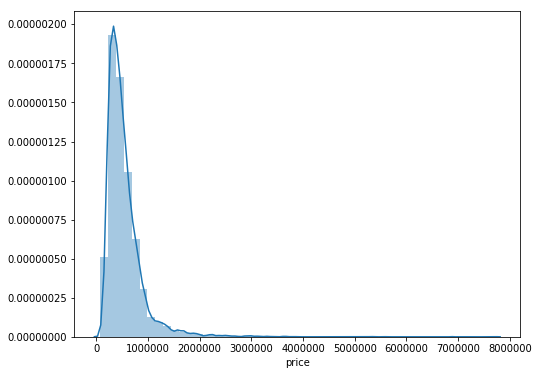

In [7]:
f, ax = plt.subplots(figsize = (8,6))
sns.distplot(df_train['price'])

In [8]:
print('Skewness: {}'.format(df_train["price"].skew()))
print('Kurtosis: {}'.format(df_train['price'].kurt()))

Skewness: 4.290252396939529
Kurtosis: 40.15491919350329


### Normalize 필요

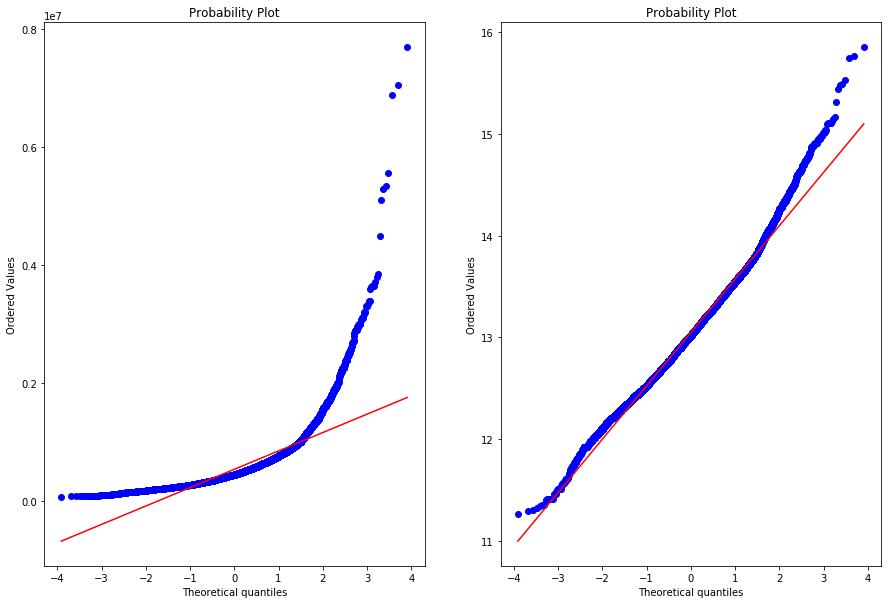

In [9]:
fig = plt.figure(figsize = (15,10))
fig.add_subplot(1,2,1)
res = stats.probplot(df_train['price'], plot=plt)

fig.add_subplot(1,2,2)
res = stats.probplot(np.log1p(df_train['price']), plot=plt)
#log1p, 로그 취했을 때 세부값까지 가져옴

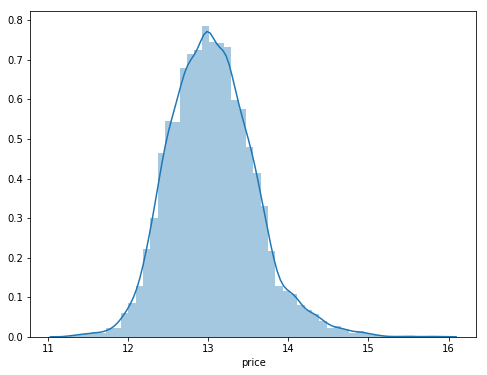

In [10]:
df_train['price'] = np.log1p(df_train['price'])
f, ax = plt.subplots(figsize=(8,6))
sns.distplot(df_train['price']) #모양이 예뻐졌다.

## 변수시각화 ( 반응변수 )
* 피어슨 상관관계 : 연속형 변수에 사용
* 스피어만 순위 상관관계 : 범주형 변수도 포함되었을 경우에 사용

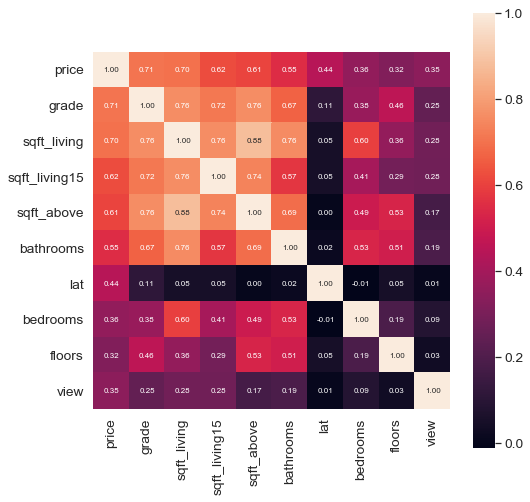

In [11]:
#스피어만을 살펴보자
k = 10 #num of vars
corrmat = abs(df_train.corr(method='spearman'))
cols = corrmat.nlargest(k, 'price').index
cm = np.corrcoef(df_train[cols].values.T)

sns.set(font_scale=1.25)
f, ax = plt.subplots(figsize = (8,8))
hm = sns.heatmap(cm, cbar=True, annot=True, square=True,
                fmt='.2f', annot_kws={'size':8}, 
                 yticklabels = cols.values, xticklabels = cols.values)

plt.show()
                     

목적변수와 관련 높은 변수 price - grade, sqft_living, sqft_living15

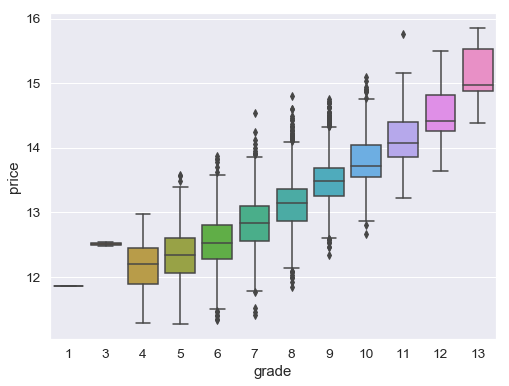

In [12]:
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.boxplot(x='grade',y='price', data=data)

집의 등급이 높으면 가격도 올라간다, 6,7,8,9에서 보이는 많은 이상치  
8, 11 에서 보이는 차이가 큰 이상치

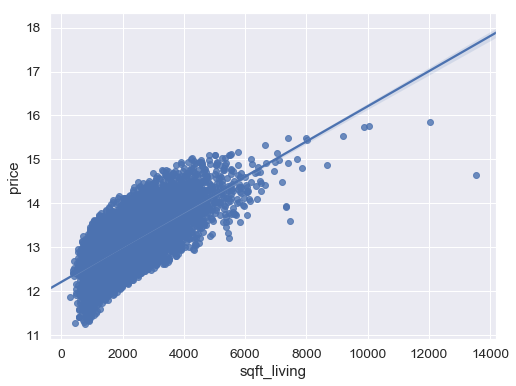

In [13]:
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x = 'sqft_living', y = 'price', data=data)

price 14 15 구간에서 이상치로 보이는 데이터가 발견된다. 확인해야 할 부분

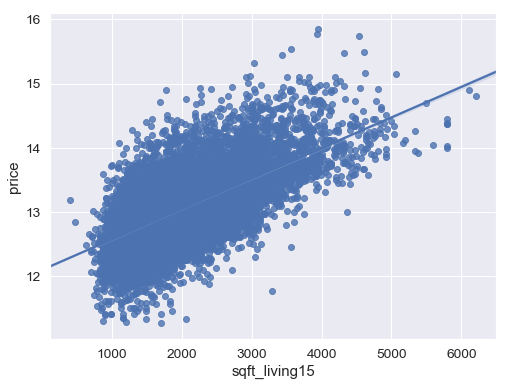

In [14]:
data = pd.concat([df_train['price'], df_train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize= (8,6))
fig = sns.regplot(x = 'sqft_living15', y = 'price', data=data)

15년도를 기준, 분산이 굉장히 크다는 것을 알 수 있음, 재겆축의 영향??  
분산을 줄이기 위해 적절한 feature engineering이 필요

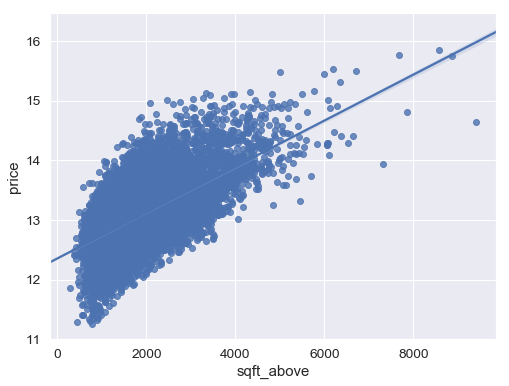

In [15]:
data = pd.concat([df_train['price'], df_train['sqft_above']], axis=1)
f, ax = plt.subplots(figsize=(8,6))
fig = sns.regplot(x = 'sqft_above', y = 'price', data=data)

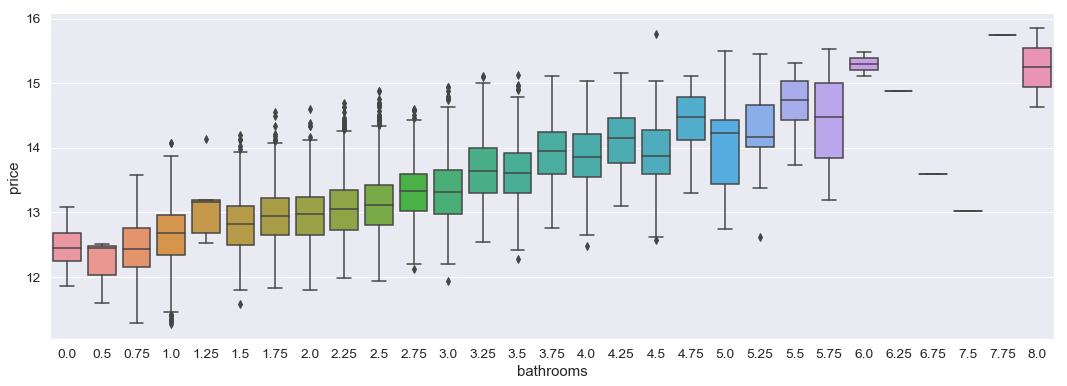

In [16]:
data = pd.concat([df_train['price'], df_train['bathrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bathrooms', y="price", data=data)

* 0.5 : 세면대, 화장실
* 0.75 : 세면대, 화장실, 샤워실
* 1 : 세면대, 화장실, 샤워실, 욕조

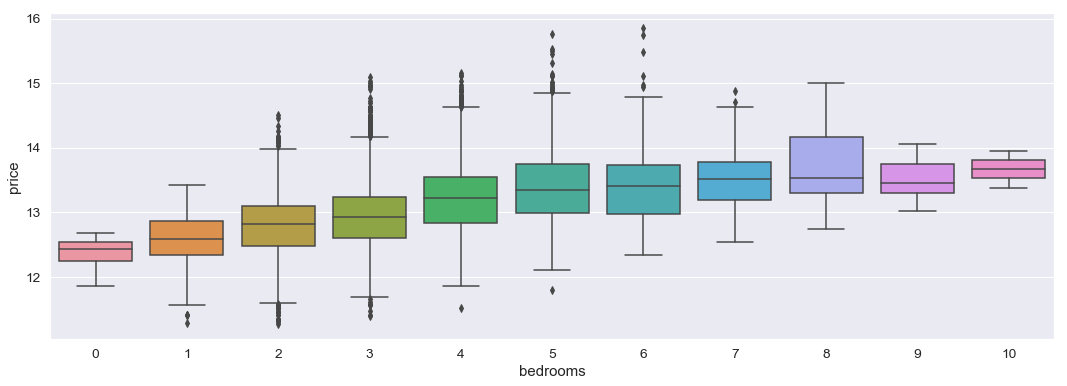

In [17]:
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(18, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

In [18]:
max(df_test['bedrooms'])

33

test 데이터에는 방이 30개가 넘는 게 발견됨.

lat(위도)에 대하여, Seatle쪽은 위쪽으로 갈 수록 집값이 비싸다고 함.

### Uniqueness

In [19]:
import plotly

In [20]:
plotly.graph_objs

<module 'plotly.graph_objs' from '/Users/sanghyub/anaconda/lib/python3.6/site-packages/plotly/graph_objs/__init__.py'>

In [21]:
### 유니크 갯수 계산
train_unique = []
columns = ['bedrooms','bathrooms','floors','waterfront','view','condition','grade']

for i in columns:
    train_unique.append(len(df_train[i].unique()))
unique_train = pd.DataFrame()
unique_train['Columns'] = columns
unique_train['Unique_value'] = train_unique

data = [
    plotly.graph_objs.Bar(
        x = unique_train['Columns'],
        y = unique_train['Unique_value'],
        name = 'Unique value in features',
        textfont=dict(size=20),
        marker=dict(
        line=dict(
            #width= 2,
        )
    )
    ),
    ]
layout= plotly.graph_objs.Layout(
        title= "Unique Value By Column",
        xaxis= dict(title='Columns', ticklen=5, zeroline=False, gridwidth=2),
        yaxis= dict(title='Value Count', ticklen=5, gridwidth=2),
        showlegend=True
    )
fig = plotly.graph_objs.Figure(data=data, layout=layout)
plotly.plotly.iplot(fig, filename='skin')

view의 유니크갯수가 5인걸로 보니 grade같이 순위형변수로 생각되어지고 waterfront의 경우는 2개로 있다/없다는 상징하는 것 같습니다.

## Preprocessing

* 이상치 확인해야 될 columns
     - sqft_living, grade, bedrooms

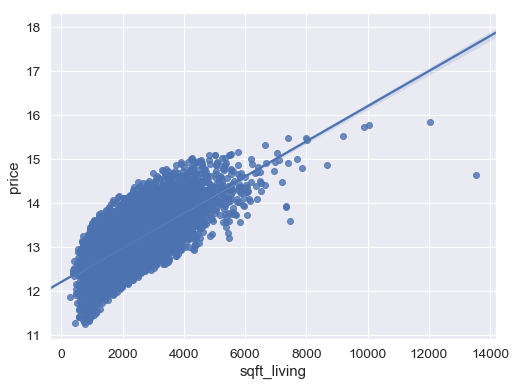

In [22]:
# sqft_living visualize
data = pd.concat([df_train['price'], df_train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [23]:
# 13000보다 큰 데이터를 확인
df_train.loc[df_train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,20140505T000000,14.639686,7,8.0,13540,307752,3.0,0,4,3,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


In [ ]:
df_train = df_train.loc[df_train['id']!=8990]

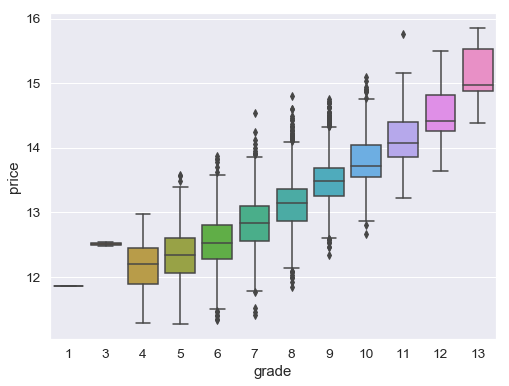

In [ ]:
# grade
data = pd.concat([df_train['price'], df_train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [ ]:
df_train.loc[(df_train['price']>14.7) & (df_train['grade'] ==8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,20140813T000000,14.808763,5,4.0,4230,27295,2.0,1,4,3,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [ ]:
df_train.loc[(df_train['price']>15.5) & (df_train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,20140611T000000,15.77031,5,4.5,10040,37325,2.0,1,2,3,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


왜 가격이 높은 걸까 생각

In [ ]:
df_train = df_train.loc[df_train['id']!=456]
df_train = df_train.loc[df_train['id']!=7259]
df_train = df_train.loc[df_train['id']!=2777]

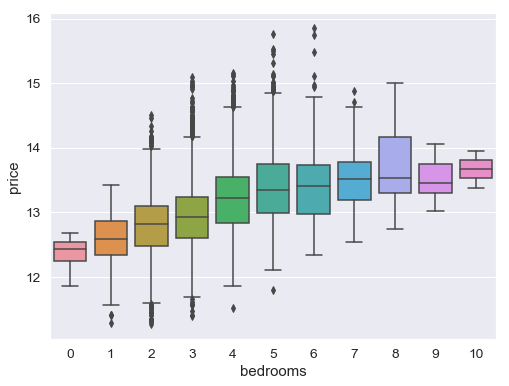

In [ ]:
# bedrooms
data = pd.concat([df_train['price'], df_train['bedrooms']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='bedrooms', y="price", data=data)

10이상 부터는 증가하지 않는다?

In [ ]:
df_train.loc[df_train['bedrooms']>=10]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
9280,9280,20140814T000000,13.953533,10,5.25,4590,10920,1.0,0,2,3,9,2500,2090,2008,0,98004,47.5861,-122.113,2730,10400
10575,10575,20141029T000000,13.384729,10,2.00,3610,11914,2.0,0,0,4,7,3010,600,1958,0,98006,47.5705,-122.175,2040,11914


In [ ]:
df_test.loc[df_test['bedrooms']>=10]

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2584,17619,20140821T000000,11,3.00,3000,4960,2.0,0,0,3,7,2400,600,1918,1999,98106,47.5560,-122.363,1420,4960
4710,19745,20140625T000000,33,1.75,1620,6000,1.0,0,0,5,7,1040,580,1947,0,98103,47.6878,-122.331,1330,4700
5775,20810,20141229T000000,10,3.00,2920,3745,2.0,0,0,4,7,1860,1060,1913,0,98105,47.6635,-122.320,1810,3745


### Normalize

In [ ]:
skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    df_train[c] = np.log1p(df_train[c].values)
    df_test[c] = np.log1p(df_test[c].values)

In [ ]:
for df in [df_train,df_test]:
    df['date'] = df['date'].apply(lambda x: x[0:8])
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [ ]:
for df in [df_train,df_test]:
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    df['grade_condition'] = df['grade'] * df['condition']
    df['sqft_total'] = df['sqft_living'] + df['sqft_lot']
    df['sqft_total_size'] = df['sqft_living'] + df['sqft_lot'] + df['sqft_above'] + df['sqft_basement']
    df['sqft_total15'] = df['sqft_living15'] + df['sqft_lot15'] 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)
    df['date'] = df['date'].astype('int')

아래는 집값 같은 경우는 비슷한 지역에 영향을 받아서 그것을 코드로 구현한 것 입니다. 주의해야 할 점은 단순 집값이 아니라 평당 가격을 써야 한다는 점 입니다 !!!

In [ ]:
df_train['per_price'] = df_train['price']/df_train['sqft_total_size']
zipcode_price = df_train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
df_train = pd.merge(df_train,zipcode_price,how='left',on='zipcode')
df_test = pd.merge(df_test,zipcode_price,how='left',on='zipcode')
del df_train['per_price']

In [ ]:
zipcode_price

,zipcode,mean,var
0,98001,0.491304,0.002462
1,98002,0.507602,0.001960
2,98003,0.484890,0.002909
3,98004,0.507231,0.003964
4,98005,0.477376,0.003489
5,98006,0.480825,0.003529
6,98007,0.508746,0.003607
7,98008,0.497547,0.003520
8,98010,0.489106,0.001948
9,98011,0.494746,0.003174


## Modeling
#### Ridge Regression

Text(0,0.5,'score')

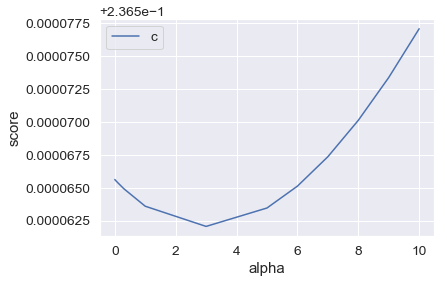

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import RidgeCV

y_reg = df_train['price']
del df_train['price']
del df_train['id']
test_id = df_test['id']
del df_test['id']

kfolds = KFold(n_splits=5, shuffle=True, random_state=42)

def cv_rmse(model):
    rmse = np.sqrt(-cross_val_score(model, df_train, y_reg, 
                                   scoring="neg_mean_squared_error", 
                                   cv = kfolds))
    return(rmse)

def ridge_selector(k):
    ridge_model = make_pipeline(RobustScaler(),
                                RidgeCV(alphas = [k],
                                        cv=kfolds)).fit(df_train, y_reg)
    
    ridge_rmse = cv_rmse(ridge_model).mean()
    return(ridge_rmse)

r_alphas = [.0001, .0003, .0005, .0007, .0009, 
          .01, 0.05, 0.1, 0.3, 1, 3, 5,6,7,8,9,10]

ridge_scores = []
for alpha in r_alphas:
    score = ridge_selector(alpha)
    ridge_scores.append(score)
    
plt.plot(r_alphas, ridge_scores, label='Ridge')
plt.legend('center')
plt.xlabel('alpha')
plt.ylabel('score')

In [ ]:
alphas_alt = [5.8,5.9,6,6.1,6.2,6.3,6.4,6.5,6.6,6.7,6.8,6.9,7]

ridge_model2 = make_pipeline(RobustScaler(),
                            RidgeCV(alphas = alphas_alt,
                                    cv=kfolds)).fit(df_train, y_reg)

print("Ridge rmse : ",cv_rmse(ridge_model2).mean())

Ridge rmse :  0.23656473662570932


In [ ]:
print("Best of alpha in ridge model :" ,ridge_model2.steps[1][1].alpha_)

Best of alpha in ridge model : 5.8


[Text(0.5,0,'Penalized Regression Coefficients')]

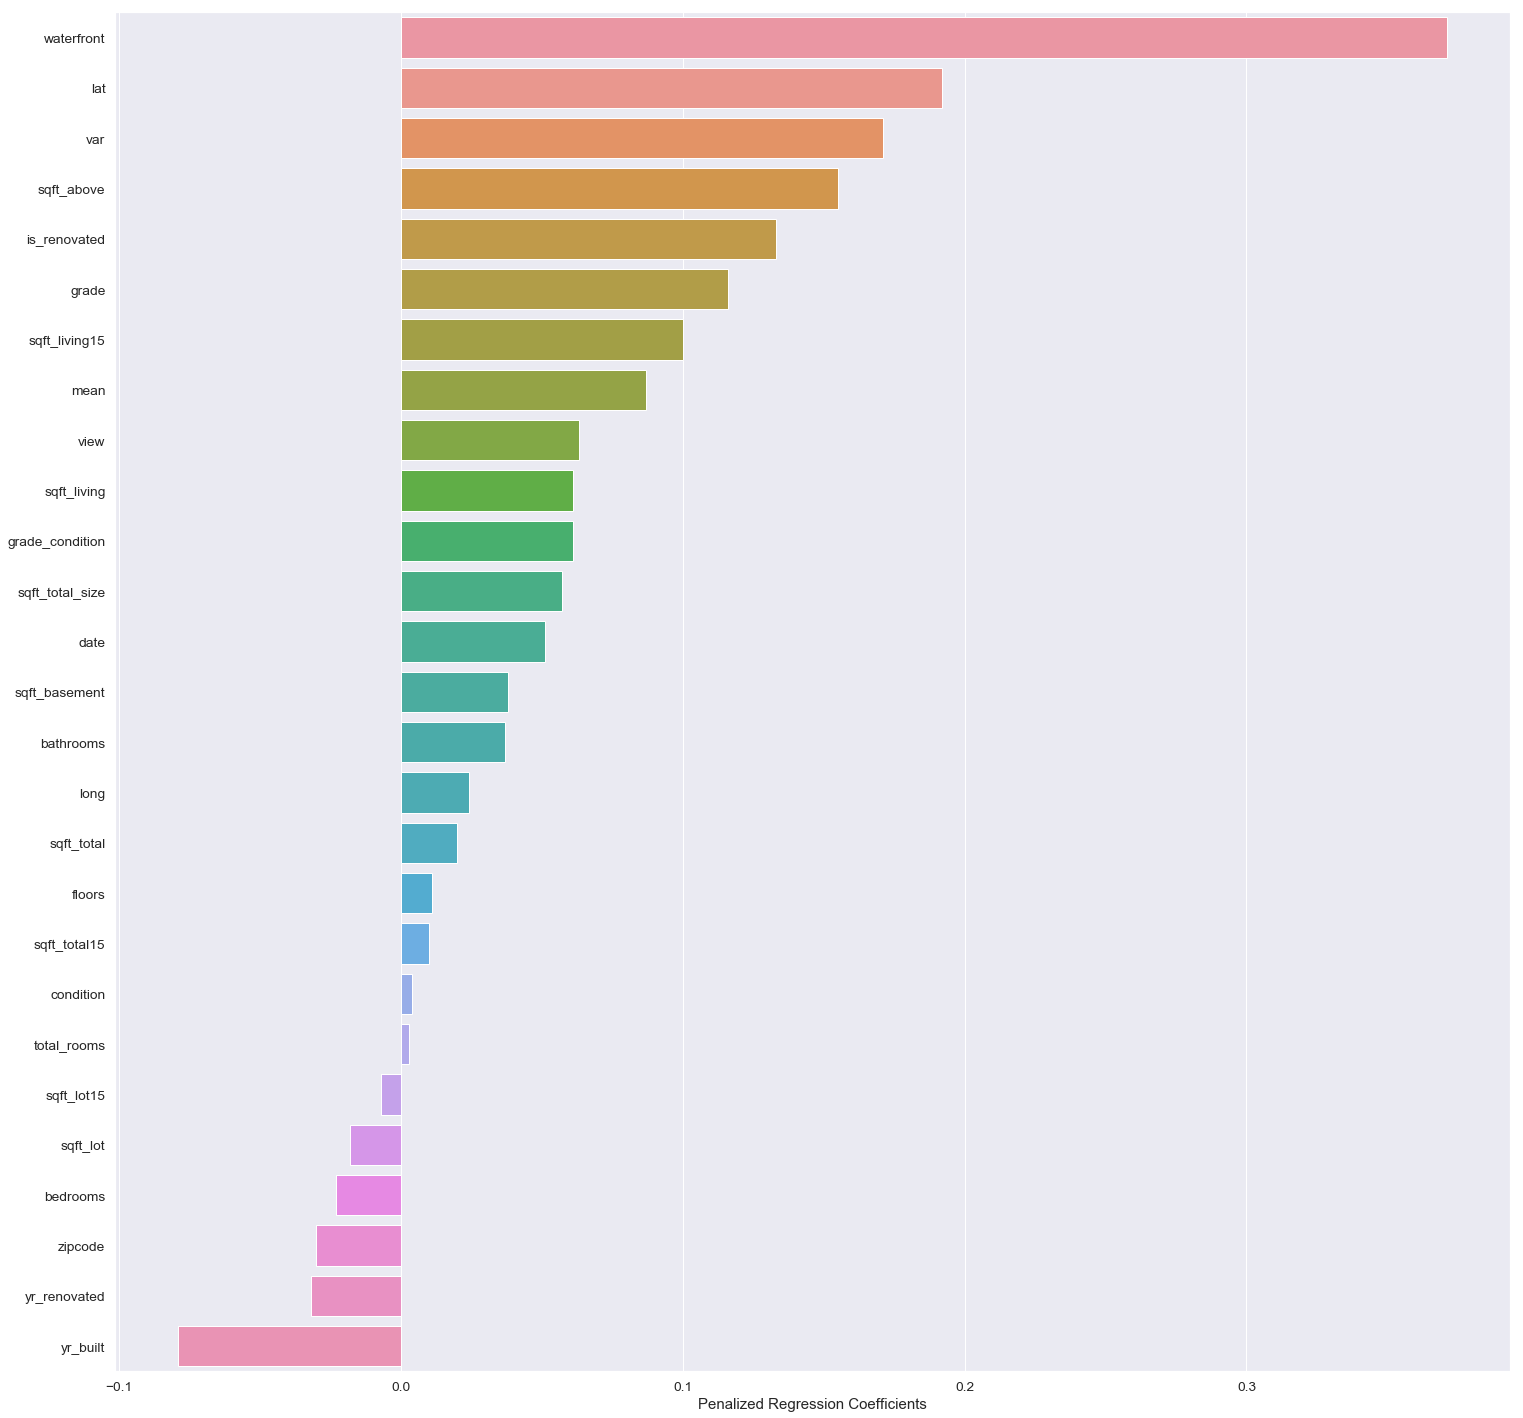

In [ ]:
ridge_coef = pd.DataFrame(np.round_(ridge_model2.steps[1][1].coef_, decimals=3), 
df_test.columns, columns = ["penalized_regression_coefficients"])
# remove the non-zero coefficients
ridge_coef = ridge_coef[ridge_coef['penalized_regression_coefficients'] != 0]
# sort the values from high to low
ridge_coef = ridge_coef.sort_values(by = 'penalized_regression_coefficients', 
ascending = False)

# plot the sorted dataframe
fig = plt.figure(figsize = (25,25))
ax = sns.barplot(x = 'penalized_regression_coefficients', y= ridge_coef.index , 
data=ridge_coef)
ax.set(xlabel='Penalized Regression Coefficients')

## GBM

#### LightGBM

In [ ]:
train_columns = [c for c in df_train.columns if c not in ['id']]

In [ ]:
train_columns

['date',
 'bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'waterfront',
 'view',
 'condition',
 'grade',
 'sqft_above',
 'sqft_basement',
 'yr_built',
 'yr_renovated',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'total_rooms',
 'grade_condition',
 'sqft_total',
 'sqft_total_size',
 'sqft_total15',
 'is_renovated',
 'mean',
 'var']

In [ ]:
import lightgbm as lgb
from sklearn.metrics import mean_squared_error


param = {'num_leaves': 31,
         'min_data_in_leaf': 30, 
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.015,
         "min_child_samples": 20,
         "boosting": "gbdt",
         "feature_fraction": 0.9,
         "bagging_freq": 1,
         "bagging_fraction": 0.9 ,
         "bagging_seed": 11,
         "metric": 'rmse',
         "lambda_l1": 0.1,
         "verbosity": -1,
         "nthread": 4,
         "random_state": 4950}
         
#prepare fit model with cross-validation
folds = KFold(n_splits=5, shuffle=True, random_state=42)
oof = np.zeros(len(df_train))
predictions = np.zeros(len(df_test))
feature_importance_df = pd.DataFrame()

#run model
for fold_, (trn_idx, val_idx) in enumerate(folds.split(df_train)):
    trn_data = lgb.Dataset(df_train.iloc[trn_idx][train_columns], label=y_reg.iloc[trn_idx])#, categorical_feature=categorical_feats)
    val_data = lgb.Dataset(df_train.iloc[val_idx][train_columns], label=y_reg.iloc[val_idx])#, categorical_feature=categorical_feats)

    num_round = 10000
    clf = lgb.train(param, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=500, early_stopping_rounds = 100)
    oof[val_idx] = clf.predict(df_train.iloc[val_idx][train_columns], num_iteration=clf.best_iteration)
    #feature importance
    fold_importance_df = pd.DataFrame()
    fold_importance_df["Feature"] = train_columns
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["fold"] = fold_ + 1
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
    #predictions
    predictions += clf.predict(df_test[train_columns], num_iteration=clf.best_iteration) / folds.n_splits
    
cv = np.sqrt(mean_squared_error(oof, y_reg))
print(cv)
#kernel dead